In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from sklearn.preprocessing import normalize

## Libraries and Filesystem Setup

In [4]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import scipy

### Import LDA document vectors

In [5]:
#tfidf_matrix = np.load(open("../processed_files/tfidf_matrix.npy"))
tfidf_matrix = scipy.sparse.load_npz('../../processed_files/tfidf_matrix.npz')
df_merged = pickle.load(open("../../processed_files/df_merged.pickle", "rb"))

In [6]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED
0,0-my.com,0-my.com related searches: related searches:,"[mycom, related, searches, related, searches]","[0, -, m, y, ., c, o, m, , r, e, l, a, t, e, ..."
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ..."
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailable, purchase, wwwvcom, welcome, uu...","[0, 1, 1, 8, 7, ., c, o, m, , i, s, , a, v, ..."
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dnsir, ir, hits, construction, coming, so...","[0, 2, 7, ., i, r, , -, , d, n, s, 4, ., i, ..."
4,03h.org,february | 2014 | online marketing review sear...,"[february, online, marketing, review, search, ...","[f, e, b, r, u, a, r, y, , |, , 2, 0, 1, 4, ..."


In [7]:
df_merged.shape

(12975, 4)

In [8]:
print(tfidf_matrix.shape)
print(tfidf_matrix[0].shape)

(12968, 272069)
(1, 272069)


## tfidf

In [9]:
num_clusters = 20
algorithm = 'full'

In [10]:
%%time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0, algorithm=algorithm).fit(tfidf_matrix)

CPU times: user 18min 56s, sys: 1min 6s, total: 20min 2s
Wall time: 2min 46s


In [11]:
kmeans.labels_

array([ 9,  2,  0, ..., 16, 17, 12], dtype=int32)

In [12]:
index_cluster = zip(range(len(kmeans.labels_)), kmeans.labels_)
index_cluster_dict = dict(index_cluster)
index_cluster_dict[456]

11

In [13]:
cluster_index = list(zip(kmeans.labels_, range(len(kmeans.labels_))))

In [14]:
cluster_list = dict()
for i in range(num_clusters):
    cluster_list[i] = list(filter(lambda row: row[0] == i, cluster_index))

In [15]:
cluster_list[0]

[(0, 2),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 13),
 (0, 17),
 (0, 18),
 (0, 20),
 (0, 21),
 (0, 31),
 (0, 66),
 (0, 77),
 (0, 86),
 (0, 96),
 (0, 99),
 (0, 104),
 (0, 135),
 (0, 136),
 (0, 147),
 (0, 150),
 (0, 151),
 (0, 155),
 (0, 156),
 (0, 162),
 (0, 163),
 (0, 165),
 (0, 171),
 (0, 196),
 (0, 197),
 (0, 237),
 (0, 245),
 (0, 261),
 (0, 278),
 (0, 325),
 (0, 335),
 (0, 389),
 (0, 402),
 (0, 407),
 (0, 485),
 (0, 486),
 (0, 500),
 (0, 534),
 (0, 561),
 (0, 563),
 (0, 578),
 (0, 583),
 (0, 584),
 (0, 606),
 (0, 647),
 (0, 656),
 (0, 673),
 (0, 679),
 (0, 693),
 (0, 716),
 (0, 771),
 (0, 812),
 (0, 813),
 (0, 831),
 (0, 910),
 (0, 912),
 (0, 947),
 (0, 968),
 (0, 1010),
 (0, 1077),
 (0, 1102),
 (0, 1182),
 (0, 1212),
 (0, 1250),
 (0, 1255),
 (0, 1275),
 (0, 1277),
 (0, 1341),
 (0, 1414),
 (0, 1424),
 (0, 1433),
 (0, 1444),
 (0, 1489),
 (0, 1537),
 (0, 1645),
 (0, 1649),
 (0, 1728),
 (0, 1729),
 (0, 1730),
 (0, 1749),
 (0, 1765),
 (0, 1784),
 (0, 1786),
 (0, 1837),
 (0, 1862),
 (0, 1927),
 

In [16]:
print(kmeans.labels_.shape)
print(kmeans.cluster_centers_.shape)

(12968,)
(20, 272069)


In [17]:
import statistics

# index is cluster index
def intracluster_similarity(index):
    cluster_centroid = kmeans.cluster_centers_[index]
    dist_list = []
    cluster = cluster_list[index]
    for i in cluster:
        distance = np.linalg.norm(cluster_centroid-tfidf_matrix[i[1]])
        dist_list.append(distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)

    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    
    return avg, variance

In [18]:
intracluster_similarity(19)

(0.9030913340279005, 0.003019094490180988)

In [19]:
# index is cluster / cluster id
def generate_raw_content_cluster_df(index):
    index_list = cluster_list[index]
    index_list = [x[1] for x in index_list]
    cluster_seed = df_merged.loc[index].to_frame().T
    #cluster_df = df_merged.loc[index_list[1:]]
    cluster_df = df_merged.loc[index_list[1:]]
    combined = pd.concat([cluster_seed, cluster_df])
    combined['cluster'] = index
    return combined

In [20]:
generate_raw_content_cluster_df(1)

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED,cluster
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",1
65,1stoplight.com,about a boy… – storyteller from a one-stopligh...,"[boy…, –, storyteller, onestoplight, town, ope...","[a, b, o, u, t, , a, , b, o, y, …, , –, , ...",1
71,21stcenturysecrets.com,screenshot – 21st century secrets behind the s...,"[screenshot, –, st, century, secrets, behind, ...","[s, c, r, e, e, n, s, h, o, t, , –, , 2, 1, ...",1
90,2fingersberben.com,i was wrong about being pro-life – vanessa ber...,"[wrong, prolife, –, vanessa, berben, writer, c...","[i, , w, a, s, , w, r, o, n, g, , a, b, o, ...",1
93,2mcr.org.au,about macarthur community radio - 100.3fm maca...,"[macarthur, community, radio, fm, macarthur, c...","[a, b, o, u, t, , m, a, c, a, r, t, h, u, r, ...",1
107,365daysoflebanon.com,how it started | 365 days of lebanon one post ...,"[started, days, lebanon, one, post, day, leban...","[h, o, w, , i, t, , s, t, a, r, t, e, d, , ...",1
108,365gas.co.uk,365 gas | kirkintilloch gas bottles | glasgow ...,"[gas, kirkintilloch, gas, bottles, glasgow, de...","[3, 6, 5, , g, a, s, , |, , k, i, r, k, i, ...",1
120,3dbrokers.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ...",1
170,94717.us,zipcode.us × find a .us domain there are many ...,"[zipcodeus, ×, find, us, domare, many, registr...","[z, i, p, c, o, d, e, ., u, s, , ×, , f, i, ...",1
200,abbottoilservices.com,abbott oil services limited engineering abbott...,"[abbott, oil, services, limited, engineering, ...","[a, b, b, o, t, t, , o, i, l, , s, e, r, v, ...",1


In [21]:
avg_list = []
variance_list = []

for i in range(num_clusters):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x1a4a440c18>,
 <a list of 11 Text xticklabel objects>)

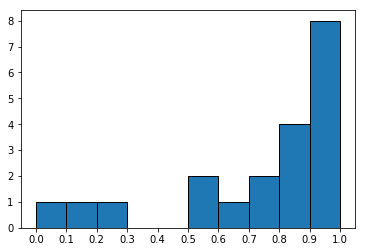

In [22]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

## Intercluster Similarity

In [23]:
def intercluster_dist():
    indices = range(len(kmeans.cluster_centers_))
    centroid_centroid_distance = {}
    values = []
    for i in indices:
        for j in indices:
            if i < j:
                key = str(i) + "::" + str(j)
                distance = np.linalg.norm(kmeans.cluster_centers_[i] - kmeans.cluster_centers_[j])
                centroid_centroid_distance[key] = distance
                values.append(distance)
    return centroid_centroid_distance, values

## number of clusters = 20

In [24]:
intercluster_distances, values = intercluster_dist()
#print('distances', values)
print('average', np.average(values))

average 0.7856770451960711
